In [2]:
import torch
import torch.nn as nn
from torch.nn import Transformer
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import os
import math
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

In [3]:
dataset = pd.read_csv("C:/Users/ksmin/DeepLearning/dataset/archive (4)/stock_yfinance_data.csv")

print(dataset.shape)
print(dataset.columns)
print(dataset.head()) #각각의 stock dataset에는 stock name이 있다.

(6300, 8)
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Stock Name'],
      dtype='object')
         Date        Open        High         Low       Close   Adj Close  \
0  2021-09-30  260.333344  263.043335  258.333344  258.493347  258.493347   
1  2021-10-01  259.466675  260.260010  254.529999  258.406677  258.406677   
2  2021-10-04  265.500000  268.989990  258.706665  260.510010  260.510010   
3  2021-10-05  261.600006  265.769989  258.066681  260.196655  260.196655   
4  2021-10-06  258.733337  262.220001  257.739990  260.916656  260.916656   

     Volume Stock Name  
0  53868000       TSLA  
1  51094200       TSLA  
2  91449900       TSLA  
3  55297800       TSLA  
4  43898400       TSLA  


In [4]:
print(dataset.describe()) #statistic dataset

              Open         High          Low        Close    Adj Close  \
count  6300.000000  6300.000000  6300.000000  6300.000000  6300.000000   
mean    174.748195   177.594589   171.734715   174.657624   173.756012   
std     134.989675   136.795419   133.049955   134.949601   134.582934   
min      11.050000    11.210000    10.610000    11.060000    10.837500   
25%      78.170002    79.891003    76.792501    78.110001    78.110001   
50%     145.475128   147.475006   143.501251   145.505005   144.248146   
75%     225.665001   230.662498   221.452496   225.785000   225.785000   
max     692.349976   700.989990   686.090027   691.690002   691.690002   

             Volume  
count  6.300000e+03  
mean   2.906806e+07  
std    3.342181e+07  
min    3.078000e+05  
25%    5.857700e+06  
50%    1.518830e+07  
75%    4.122928e+07  
max    3.116452e+08  


In [5]:
for i in dataset.columns:
    if i == "Date":
        continue
    else:
        print(i,'\n', dataset[i].unique(),'\n')
        

Open 
 [260.33334351 259.4666748  265.5        ...  14.27999973  14.57999992
  12.55000019] 

High 
 [263.04333496 260.26000977 268.98999023 ...  14.80000019  13.42099953
  12.85000038] 

Low 
 [258.33334351 254.52999878 258.70666504 ...  13.57999992  12.68999958
  11.85000038] 

Close 
 [258.49334717 258.40667725 260.51000977 ...  14.36999989  13.32999992
  12.10999966] 

Adj Close 
 [258.49334717 258.40667725 260.51000977 ...  14.36999989  13.32999992
  12.10999966] 

Volume 
 [53868000 51094200 91449900 ... 21160800 31799400 33044800] 

Stock Name 
 ['TSLA' 'MSFT' 'PG' 'META' 'AMZN' 'GOOG' 'AMD' 'AAPL' 'NFLX' 'TSM' 'KO'
 'F' 'COST' 'DIS' 'VZ' 'CRM' 'INTC' 'BA' 'BX' 'NOC' 'PYPL' 'ENPH' 'NIO'
 'ZS' 'XPEV'] 



In [6]:
print(dataset["Stock Name"].unique())

print(dataset[["Stock Name"]].value_counts()) #AAPL은 252개

['TSLA' 'MSFT' 'PG' 'META' 'AMZN' 'GOOG' 'AMD' 'AAPL' 'NFLX' 'TSM' 'KO'
 'F' 'COST' 'DIS' 'VZ' 'CRM' 'INTC' 'BA' 'BX' 'NOC' 'PYPL' 'ENPH' 'NIO'
 'ZS' 'XPEV']
Stock Name
AAPL          252
META          252
XPEV          252
VZ            252
TSM           252
TSLA          252
PYPL          252
PG            252
NOC           252
NIO           252
NFLX          252
MSFT          252
KO            252
AMD           252
INTC          252
GOOG          252
F             252
ENPH          252
DIS           252
CRM           252
COST          252
BX            252
BA            252
AMZN          252
ZS            252
Name: count, dtype: int64


In [8]:
apple_dataset = dataset[dataset['Stock Name']=='AAPL']
tesla_dataset = dataset[dataset['Stock Name']=='TSLA']
google_dataset = dataset[dataset['Stock Name']=='GOOG']

print(apple_dataset.shape)
print(apple_dataset.tail())

(252, 8)
            Date        Open        High         Low       Close   Adj Close  \
2011  2022-09-23  151.190002  151.470001  148.559998  150.429993  150.180862   
2012  2022-09-26  149.660004  153.770004  149.639999  150.770004  150.520309   
2013  2022-09-27  152.740005  154.720001  149.949997  151.759995  151.508667   
2014  2022-09-28  147.639999  150.639999  144.839996  149.839996  149.591843   
2015  2022-09-29  146.100006  146.720001  140.679993  142.479996  142.244034   

         Volume Stock Name  
2011   96029900       AAPL  
2012   93339400       AAPL  
2013   84442700       AAPL  
2014  146691400       AAPL  
2015  128138200       AAPL  


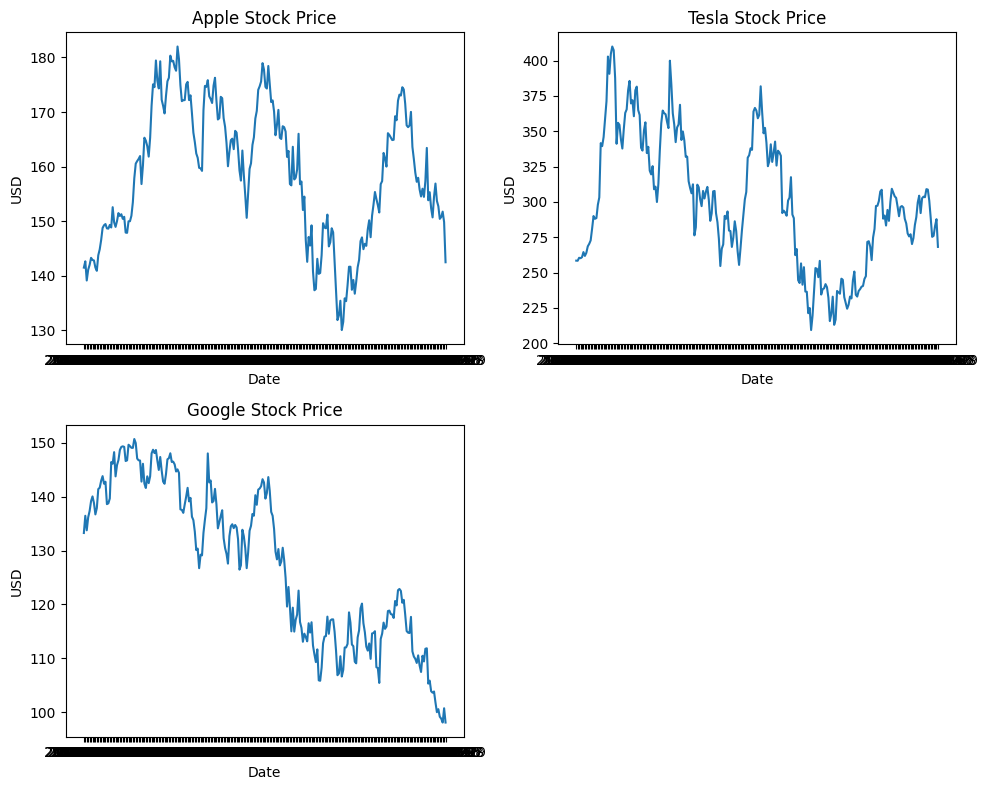

In [9]:
# fig, ax를 설정하고, 2x2 그리드로 서브플롯 생성
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

# APPLE Stock
ax[0, 0].plot(apple_dataset["Date"], apple_dataset["Close"])
ax[0, 0].set(xlabel="Date", ylabel="USD", title="Apple Stock Price")

#Tesla Stock
ax[0, 1].plot(tesla_dataset["Date"], tesla_dataset["Close"])
ax[0, 1].set(xlabel="Date", ylabel="USD", title="Tesla Stock Price")

#Google Stock
ax[1, 0].plot(google_dataset["Date"], google_dataset["Close"])
ax[1, 0].set(xlabel="Date", ylabel="USD", title="Google Stock Price")

ax[1, 1].axis('off')  #비활성화

plt.tight_layout() #layout 조정
plt.show()


## Black-Litterman

- 필요한 것은 수익률에 대한 정보, 사용자들의 시각, 시장 covariance matrix


In [10]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler

class StockDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data = data.astype("float32")
        self.seq_len = seq_len
    
    def __len__(self):
        return len(self.data) - self.seq_len
    
    def __getitem__(self, idx):
        return self.data[idx:idx+self.seq_len]

# 데이터 준비
data = pd.read_csv('C:/Users/ksmin/DeepLearning/dataset/archive (4)/stock_yfinance_data.csv')
prices = data['Close'].values.reshape(-1,1)

# 데이터 정규화
scaler = MinMaxScaler()
prices = scaler.fit_transform(prices)

print("Normalized prices shape:", prices.shape)
print("Sample of normalized prices:", prices[:5])

# 시퀀스 데이터셋 생성
seq_len = 10
dataset = StockDataset(prices, seq_len)

# Train-Test 분할
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# DataLoader 설정
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Total sequences: {len(dataset)}")
print(f"Training sequences: {len(train_dataset)}")
print(f"Testing sequences: {len(test_dataset)}")

# 데이터 샘플 확인
for batch in train_loader:
    print("Batch shape:", batch.shape)
    print("Sample sequence:\n", batch[0])
    break

Normalized prices shape: (6300, 1)
Sample of normalized prices: [[0.36353576]
 [0.36340842]
 [0.3664987 ]
 [0.36603831]
 [0.36709615]]
Total sequences: 6290
Training sequences: 5032
Testing sequences: 1258
Batch shape: torch.Size([32, 10, 1])
Sample sequence:
 tensor([[0.2418],
        [0.2427],
        [0.2487],
        [0.2472],
        [0.2473],
        [0.2456],
        [0.2446],
        [0.2512],
        [0.2478],
        [0.2407]])


In [178]:
class TransformerGenerator(nn.Module):
    def __init__(self, d_noise, d_model, nhead, num_layers, dim_feedforward, dropout, output_dim):
        super(TransformerGenerator, self).__init__()
        self.embedding = nn.Linear(d_noise, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.output_layer = nn.Linear(d_model, output_dim)
        self.tanh = nn.Tanh()
    
    def forward(self, z):
        z = self.embedding(z)  # [batch_size, d_model]
        z = z.unsqueeze(0)  # [1, batch_size, d_model]
        z = self.pos_encoder(z)
        transformer_out = self.transformer_encoder(z)
        output = self.output_layer(transformer_out.squeeze(0))
        return self.tanh(output)

class TransformerDiscriminator(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dim_feedforward, dropout):
        super(TransformerDiscriminator, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.output_layer = nn.Linear(d_model, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.embedding(x)  # [batch_size, d_model]
        x = x.unsqueeze(0)  # [1, batch_size, d_model]
        x = self.pos_encoder(x)
        transformer_out = self.transformer_encoder(x)
        output = self.output_layer(transformer_out.mean(dim=0))  # Average over sequence length
        return self.sigmoid(output)
    
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

def sample_z(batch_size, d_noise):
    return torch.randn(batch_size, d_noise)

In [179]:
# Hyperparameters
d_noise = 100
d_model = 256
nhead = 8
num_layers = 2
dim_feedforward = 64
dropout = 0.1
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dim = 50  # 실제 데이터의 특성 수
output_dim = 50  # Generator가 생성할 데이터의 특성 수

G = TransformerGenerator(d_noise, d_model, nhead, num_layers, dim_feedforward, dropout, output_dim).to(device)
D = TransformerDiscriminator(input_dim, d_model, nhead, num_layers, dim_feedforward, dropout).to(device)

# Optimizers
optimizer_G = optim.Adam(G.parameters(), lr=0.0002)
optimizer_D = optim.Adam(D.parameters(), lr=0.0002)
#loss function
criterion = nn.BCELoss()


# Check shapes
for real_data in train_loader:
    real_data = real_data.to(device)
    print("Real data shape:", real_data.shape)
    print("Real data squeezed shape:", real_data.squeeze(-1).shape)
    
    z = sample_z(batch_size, d_noise).to(device)
    fake_data = G(z)
    print("Generated data shape:", fake_data.shape)
    
    d_real_output = D(real_data.squeeze(-1))
    d_fake_output = D(fake_data.squeeze(-1))
    print("Discriminator real output shape:", d_real_output.shape)
    print("Discriminator fake output shape:", d_fake_output.shape)
    
    break

Real data shape: torch.Size([32, 50, 1])
Real data squeezed shape: torch.Size([32, 50])
Generated data shape: torch.Size([32, 50])
Discriminator real output shape: torch.Size([32, 1])
Discriminator fake output shape: torch.Size([32, 1])


In [180]:
print(torch.ones(32,1).dtype)

torch.float32


In [181]:
def run_epoch(G, D, optimizer_G, optimizer_D, criterion, device, train_loader, d_noise):
    G.train()
    D.train()
    total_loss_D, total_loss_G = 0, 0
    for real_data in train_loader:
        real_data = real_data.to(device).float().squeeze(-1)
        current_batch_size = real_data.size(0)

        # Train Discriminator
        optimizer_D.zero_grad()
        z = sample_z(current_batch_size, d_noise).to(device)
        fake_data = G(z).detach()

        real_loss = criterion(D(real_data), torch.ones(current_batch_size, 1).to(device))
        fake_loss = criterion(D(fake_data), torch.zeros(current_batch_size, 1).to(device))

        loss_D = (real_loss + fake_loss) / 2  # Average of real and fake losses
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        z = sample_z(current_batch_size, d_noise).to(device)
        fake_data = G(z)
        
        loss_G = criterion(D(fake_data), torch.ones(current_batch_size, 1).to(device))
        loss_G.backward()
        optimizer_G.step()

        total_loss_D += loss_D.item()
        total_loss_G += loss_G.item()

    return total_loss_D / len(train_loader), total_loss_G / len(train_loader)

def evaluate_model(G, D, device, test_loader, d_noise, scaler):
    G.eval()
    D.eval()

    real_correct = 0
    fake_correct = 0
    total = 0

    with torch.no_grad():
        for real_data in test_loader:
            real_data = real_data.to(device).float().squeeze(-1)
            real_output = D(real_data)
            real_pred = (real_output > 0.5).float()
            real_correct += real_pred.eq(1.0).sum().item()

            z = sample_z(real_data.size(0), d_noise).to(device)
            fake_data = G(z)
            fake_output = D(fake_data.detach())
            fake_pred = (fake_output < 0.5).float()
            fake_correct += fake_pred.eq(1.0).sum().item()

            total += real_data.size(0)

    real_acc = real_correct / total
    fake_acc = fake_correct / total

    # Generate synthetic data
    z = sample_z(100, d_noise).to(device)
    synthetic_data = G(z).detach().cpu().numpy()

    # Inverse transform the synthetic data if you used MinMaxScaler
    synthetic_data = scaler.inverse_transform(synthetic_data)

    return real_acc, fake_acc, synthetic_data

In [182]:
batch_size = 32
num_epochs = 100

# Training loop
for epoch in tqdm(range(num_epochs)):
    loss_D, loss_G = run_epoch(G, D, optimizer_G, optimizer_D, criterion, device, train_loader, d_noise)
    
    if (epoch + 1) % 10 == 0:
        real_acc, fake_acc, synthetic_data = evaluate_model(G, D, device, test_loader, d_noise, scaler)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss D: {loss_D:.4f}, Loss G: {loss_G:.4f}")
        print(f"Real Accuracy: {real_acc:.4f}, Fake Accuracy: {fake_acc:.4f}")
        #print(f"Synthetic data shape: {synthetic_data.shape}")
        print("Sample of synthetic data:")
        #print(synthetic_data[:5])  # Print first 5 synthetic sequences

# Final evaluation
real_acc, fake_acc, synthetic_data = evaluate_model(G, D, device, test_loader, d_noise, scaler)
print("Final Evaluation:")
print(f"Real Accuracy: {real_acc:.4f}, Fake Accuracy: {fake_acc:.4f}")
print(f"Synthetic data shape: {synthetic_data.shape}")

  2%|▏         | 2/100 [00:15<12:51,  7.87s/it]

Epoch [2/100], Loss D: 0.1280, Loss G: 3.9127
Real Accuracy: 1.0000, Fake Accuracy: 1.0000
Synthetic data shape: (100, 50)
Sample of synthetic data:
[[ 686.0044    501.24893   445.4979    669.7601   -368.45093  -625.97375
  -653.5187    684.6977    660.53827   688.34406   564.0028    674.5157
   676.3517    677.0922    634.30585   688.8334    619.6238    489.22382
  -646.79047  -582.01685  -578.11383  -207.70352   315.5965    690.0948
   650.0434    460.45898   689.575     684.43787   684.47565   670.33966
  -124.19919  -647.567     684.5551    667.3069    675.6038    686.1054
   685.03455   679.3882    647.3604    656.6753    682.7087    676.287
  -628.90173   684.08307  -515.8035    572.95215  -603.08765   683.0872
   684.75366   647.00854 ]
 [ 686.0656    499.1651    442.847     669.87775  -371.46252  -626.0676
  -653.37476   684.6806    660.2133    688.33746   564.64343   674.24066
   676.2684    677.13135   634.2239    688.798     619.0628    488.40085
  -647.0742   -581.977    -5

  2%|▏         | 2/100 [00:23<18:56, 11.60s/it]


KeyboardInterrupt: 

## Black-Litterman

- 필요한 것은 수익률에 대한 정보, 사용자들의 시각, 시장 covariance matrix


In [ ]:
import numpy as np
from scipy.optimize import minimize

def calculate_returns(prices):
    return np.diff(prices, axis=1) / prices[:, :-1]

def bl_model(Sigma, Q, P, Omega, pi):
    inv_Sigma = np.linalg.inv(Sigma)
    inv_Omega = np.linalg.inv(Omega)
    M_inverse = np.linalg.inv(inv_Sigma + P.T @ inv_Omega @ P)
    mu_bl = M_inverse @ (inv_Sigma @ pi + P.T @ inv_Omega @ Q)
    Sigma_bl = M_inverse
    return mu_bl, Sigma_bl

# Historical returns and covariance
historical_prices = prices.reshape(-1, seq_len)
historical_returns = calculate_returns(historical_prices)
historical_cov = np.cov(historical_returns)

# Synthetic returns and covariance
synthetic_prices = synthetic_data.reshape(-1, seq_len)
synthetic_returns = calculate_returns(synthetic_prices)
synthetic_cov = np.cov(synthetic_returns)

# Black-Litterman parameters
P = np.eye(len(historical_cov))  # Identity matrix for simplicity
Q = np.mean(historical_returns, axis=1)  # Equilibrium returns
Omega = np.diag(np.var(historical_returns, axis=1))  # Uncertainty in views
pi = np.mean(historical_returns, axis=1)  # Prior returns

# Apply Black-Litterman model
mu_bl, Sigma_bl = bl_model(historical_cov, Q, P, Omega, pi)

# Optimize portfolio
def optimize_portfolio(mu, Sigma):
    def objective(weights):
        return -weights @ mu / np.sqrt(weights @ Sigma @ weights.T)

    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(len(mu)))
    result = minimize(objective, len(mu) * [1. / len(mu)], bounds=bounds, constraints=constraints)
    return result.x

optimal_weights = optimize_portfolio(mu_bl, Sigma_bl)
print("Optimal portfolio weights:", optimal_weights)
